# digital narratives of COVID-19: frequency bar chart

In this notebook we demonstrate how to use *coveet*, a Python script that retrieves basic statistics (most frequent words, bigrams, trigrams, top users, hashtags) from our curated COVID-19 database about our collection. We visualize the results using bar charts to get a sense of top words/bigrams/trigrams/ec. over the span of a week in each geographic area. Please feel free to modify this notebook or, if you would like to preserve this version, make a copy of it by clicking "File" > "Make a Copy..."

To follow along, we recommend running the script portions piecemeal, in order.

__Author:__

* Jerry Bonnell, [j.bonnell@miami.edu](mailto:j.bonnell@miami.edu), University of Miami



## 0. Setting Up

Before we get started, let's set up the notebook by installing and importing libraries we need. The `requirements.txt` file specifies all the packages to install on your computer for this notebook. 

In [ ]:
!pip3 install -r requirements.txt  # may need to replace "pip3" with "conda"

In [35]:
import numpy as np
import pandas as pd
from coveet import count_ngrams, uniq_vocab_by_gl
from collections import Counter
from pprint import pprint
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None

## 1. Querying the database API + filtering stopwords

__NOTE__ Documentation for the coveet tool is available on the [project GitHub](https://github.com/dh-miami/narratives_covid19/tree/master/scripts/freq_analysis).

We first use coveet to query one week of tweets written in each geographic area. All of the geolocated tweets are written in Spanish, with the exception of Florida where both Spanish and English tweets are obtained. 

Furthermore, we assume that the user has prepared a list of stopwords in English and Spanish. In this example, one file contains stopwords for English and another for Spanish.

In [3]:
!python3 coveet.py query -g fl ar co ec es mx pe -l en es -d 2020-05-08 2020-05-14 -stopwords stopwords_en.txt stopwords_es.txt

Namespace(date=[datetime.datetime(2020, 5, 8, 0, 0), datetime.datetime(2020, 5, 14, 0, 0)], func=<function handle_query at 0x118407830>, geo=['fl', 'ar', 'co', 'ec', 'es', 'mx', 'pe'], lang=['en', 'es'], stopwords=['stopwords_en.txt', 'stopwords_es.txt'])
wrote df to dhcovid_2020-5-8_to_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe.csv!


The coveet script just wrote the results to a CSV file called `dhcovid_2020-5-8_to_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe.csv`. Let's load in this CSV using `pandas`.

In [2]:
df = pd.read_csv('dhcovid_2020-5-8_to_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe.csv', index_col=0)

Let's have a look at what this dataframe looks like...

In [3]:
df

,date,lang,geo,text,hashtags
0,2020-05-08,en,fl,heart tested positive keys senior living facil...,NaN
1,2020-05-08,en,fl,probable causes death pneumonia acute respirat...,NaN
2,2020-05-08,en,fl,chem trails blue angels cure government wastin...,NaN
3,2020-05-08,en,fl,lot higher whats reported unemployment soars 1...,NaN
4,2020-05-08,en,fl,intel reports deep state china use antitrump g...,NaN
...,...,...,...,...,...
224732,2020-05-14,es,co,mejores herramientas evitar propagacion manten...,#mecuidoytecuido #covid19
224733,2020-05-14,es,co,cinco abuelitos fundacion san pedro claver luc...,#covid19
224734,2020-05-14,es,co,siga recomendaciones expertos prevenir,#yomequedoencasa
224735,2020-05-14,es,co,consideran corrupcion principal problema 604 e...,#mexico


Nice :-) Let's do some quick pre-processing of this dataframe in preparation for the visualization task. Namely, we are going to convert the date column to a `datetime` object since that makes working with dates easier. We will also split the dataframe into two by subsetting the df columns, one for the tweet text and another for the hashtags.

In [4]:
df['date'] = pd.to_datetime(df['date'])
df['text'] = df['text'].str.split()
df['hashtags'] = df['hashtags'].str.split()

## 2. Retrieving top n-grams or hashtags

Let's have a look at the top 10 results in each area. First, we define some variables.

In [5]:
top_n = 10  # top 10 words
n_gram = 1  # ask for word frequency (i.e. an n-gram where n=1)

Let's toggle a variable to determine whether we will retrieve n-grams or hashtags.

In [6]:
col_name = 'text'  # set to either 'text' or 'hashtags'

We'll subset the dataframe to contain only tweets or hashtags based on this toggle variable, and drop any cells with missing values (due to a tweet consisting of a body but with no hashtags, or vice versa).  

In [7]:
df = df.dropna(subset=[col_name])

We will create another dictionary where each key is a location-language pair, and the value is a list of the top occurrences under that setting. The code here invokes a function `count_ngrams()` from coveet to prepare the top n-gram and hashtag information. 

A brief note on how these n-grams are obtained: I treat the full tweet as context, rather than adjacent neighbors, in light of how short a "tweet" unit is. For instance, when obtaining bigrams, I consider the occurrence of two words together in a tweet as bigrams, regardless of whether they are adjacent. This could lead to possibly interesting findings, but we should discuss. 

In [8]:
# counts is of the form: location, language, actual tuples
# count_ngrams returns a (default) dictionary of word tuples (ngrams) 
# with its associated frequency; we then use Counter from python collections 
# to tell us the top n most popular ones 
counts = {(g, l): Counter(count_ngrams(t, n_gram, consecutive=False)).most_common(top_n)
          for (g, l), t in df.groupby(["geo", "lang"])[col_name]}

Let's have a look at what we just did.

In [9]:
pprint(counts)

{('ar', 'es'): [(('casos',), 1789),
                (('mas',), 1490),
                (('pandemia',), 920),
                (('si',), 860),
                (('coronavirus',), 823),
                (('nuevos',), 766),
                (('hoy',), 727),
                (('salud',), 629),
                (('argentina',), 622),
                (('pais',), 582)],
 ('co', 'es'): [(('casos',), 4577),
                (('mas',), 4569),
                (('salud',), 2648),
                (('pandemia',), 2370),
                (('colombia',), 2189),
                (('si',), 2122),
                (('hoy',), 2001),
                (('nuevos',), 1889),
                (('mayo',), 1867),
                (('coronavirus',), 1866)],
 ('ec', 'es'): [(('mas',), 1357),
                (('casos',), 1019),
                (('salud',), 923),
                (('ecuador',), 726),
                (('pandemia',), 722),
                (('si',), 653),
                (('contagio',), 603),
                (('mayo',

## 3. Visualization

Now we're ready to visualize! First we initialize some `matplotlib`  settings.

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 40, 40  # setting figure size
plt.rcParams.update({'font.size': 22})  # setting font size

We create a matrix of bar charts, one for each location-language pair.

In [11]:
def plot_bar_matrix(counts):
    fig, axes = plt.subplots(4,2)
    flattened = axes.flatten()
    for i, ((geo, lang), geo_counts) in enumerate(counts.items()):
        labels = [" ".join(w) for w, _ in geo_counts]
        y = [n for _, n in geo_counts]
        cmap = plt.get_cmap('spring')
        colors = plt.get_cmap('spring')(np.linspace(0, 1, len(labels)))
        flattened[i].set_title(f"{geo} {lang}")
        flattened[i].barh(y=range(0,10), width=y, color=colors, tick_label=labels)

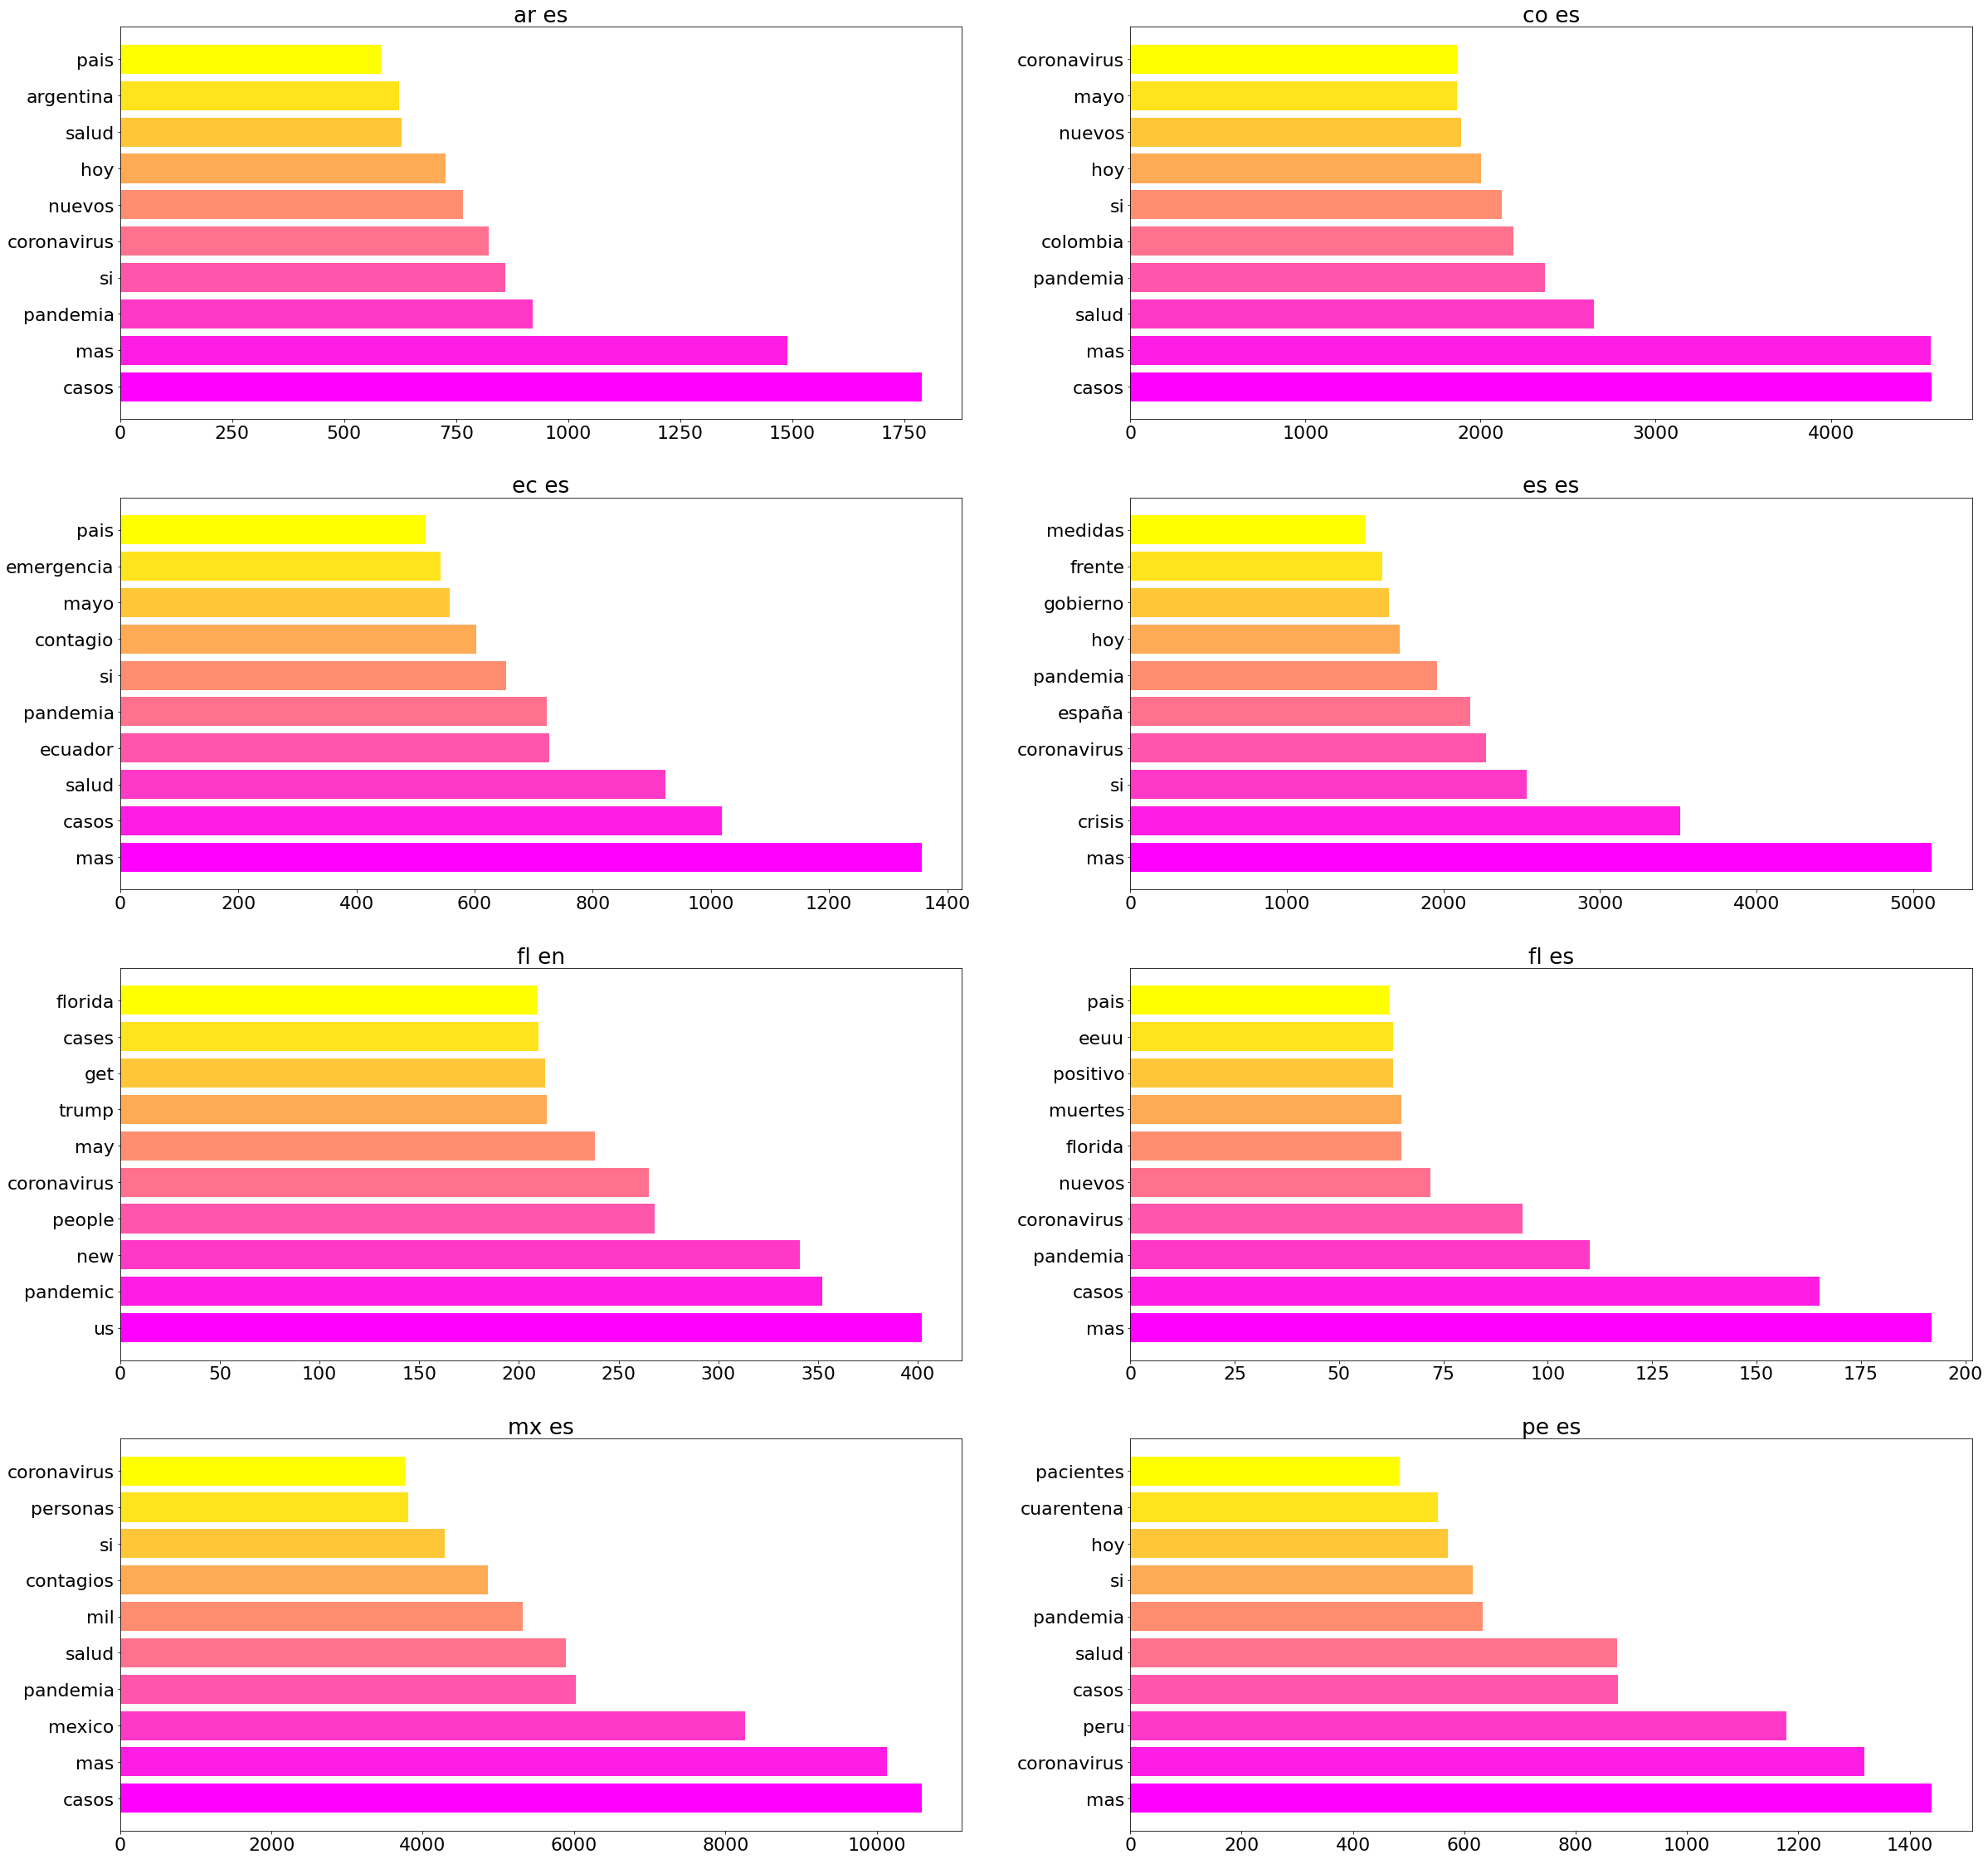

In [12]:
plot_bar_matrix(counts)

## 4. More advanced explorations 

In this final part of the notebook, I introduce two different analyses that can enable more advanced explorations of the tweet data: (1) concordance views, and (2) unique word mode. We will still be making use of the tweet data we queried earlier in the notebook, available in `df`.  

### 4.1. Concordance views

I defer to the NLTK documentation for a definition: "a *concordance* view shows us every occurrence of a given word, together with some context." The context is usually defined by a window of some number of characters. Given the short and atomic nature of tweets, it would be fair to consider the full tweet as context for the concordance view. We would also like to display the associated date of that tweet.

The work needed to find concordances with its associated date is straightforward thanks to `pandas`. We will need to prepare a new query CSV, this time without applying any preprocessing steps (e.g., filtering stopwords) so we are better able to study the context. After this CSV has been created, we will load it in using `pandas`. 

In [13]:
!python3 coveet.py query -g fl ar co ec es mx pe -l en es -d 2020-05-08 2020-05-14

Namespace(date=[datetime.datetime(2020, 5, 8, 0, 0), datetime.datetime(2020, 5, 14, 0, 0)], func=<function handle_query at 0x11d09b830>, geo=['fl', 'ar', 'co', 'ec', 'es', 'mx', 'pe'], lang=['en', 'es'], stopwords=None)
wrote df to dhcovid_2020-5-8_to_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe_no-stopwords.csv!


In [56]:
df_concord = pd.read_csv('dhcovid_2020-5-8_to_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe_no-stopwords.csv', index_col=0)
df_concord = df_concord.dropna(subset=["text"])

Now that we have `df_concord`, the remaining work needed is to filter the rows to include only those that match the given word. This filter `filt` can be as simple as a single word (tweets where `nuevo` appears) or as advanced as logical expressions (tweets where `nuevo` and `america` appears). I show examples for both. 

In [57]:
filt = lambda text: 'trump' in text  # a single word
# filt = lambda text: 'nuevo' in text and 'america' in text      # a logical expression 
# filt = lambda text: 'trump' in text and not 'china' in text    # another one to try

In [58]:
df_concord = df_concord[df_concord.apply(lambda x: filt(x["text"]), axis=1)]

In [59]:
df_concord

,date,lang,geo,text,hashtags
414,2020-05-08,es,ec,la semana pasada donald trump amenazo con nuevas tarifas contra china despues de afirmar que habia evidencia que vinculaba la con un laboratorio de alta seguridad en wuhan,#covid19
1288,2020-05-08,es,ec,un asistente de donald trump dio positivo porcovid19,NaN
1289,2020-05-08,es,ec,un asistente de donald trump dio positivo porcovid19,NaN
1301,2020-05-08,es,ec,donald trump mantiene la teoria de que el covid19 se fabrico en un laboratorio chino probablemente fue por incompetencia,NaN
1952,2020-05-09,es,ec,el expresidente de estados unidos barack obama ha calificado de desastre caotico la respuesta de donald trump a la pandemia del,#coronavirus
...,...,...,...,...,...
224538,2020-05-14,en,fl,in hindsight trumps claim to global leadership leaps out history will mark covid19 as the first time that ceased to be true us airlifts have been missing in action america cannot even supply itself,NaN
224700,2020-05-14,en,fl,team trump is just the covid19 task force tdb writing for clicks,NaN
224711,2020-05-14,en,fl,covid19 test used by trump white house may miss nearly half of positive cases nyu study,NaN
224716,2020-05-14,en,fl,when leftists say we need to suffer a little for a better world tomorrow they mean better world wo trump not wo covid19 they dont give a damn about covid,NaN


It would be useful to write this dataframe to file so let's do that. 

In [66]:
df_concord.to_csv("concordance_view.csv")

### 4.2. Unique word mode

We may be interested in obtaining words that are *unique* to a location-language pair, i.e., for an input file that contains information about `mx-es`, `es-es`, and `fl-es`, words that occur *only* in `mx-es` and not in `es-es` and `fl-es`. 

We can invoke the function `uniq_vocab_by_gl()` from *coveet* to retrieve a dictionary for a location-language pair's unique vocabulary, and filter `df` with that dictionary using `apply()` from `pandas`. Put less technically, each row of `df` will only contain words/hashtags that are unique to that location-language pair.

In [67]:
vocab_dic = uniq_vocab_by_gl(df, col_name)  # unique vocab dictionary 
# recall that col_name is a toggle variable set earlier in the notebook ("text" or "hashtags")
df[col_name] = df.apply(lambda x : set(x[col_name]) & vocab_dic[(x['geo'], x['lang'])],
                        result_type='reduce', axis=1)  # filtering tweets by that dic

Let's visualize top frequencies!

In [69]:
counts = {(g, l): Counter(count_ngrams(t, n_gram, consecutive=False)).most_common(top_n)
          for (g, l), t in df.groupby(["geo", "lang"])[col_name]}

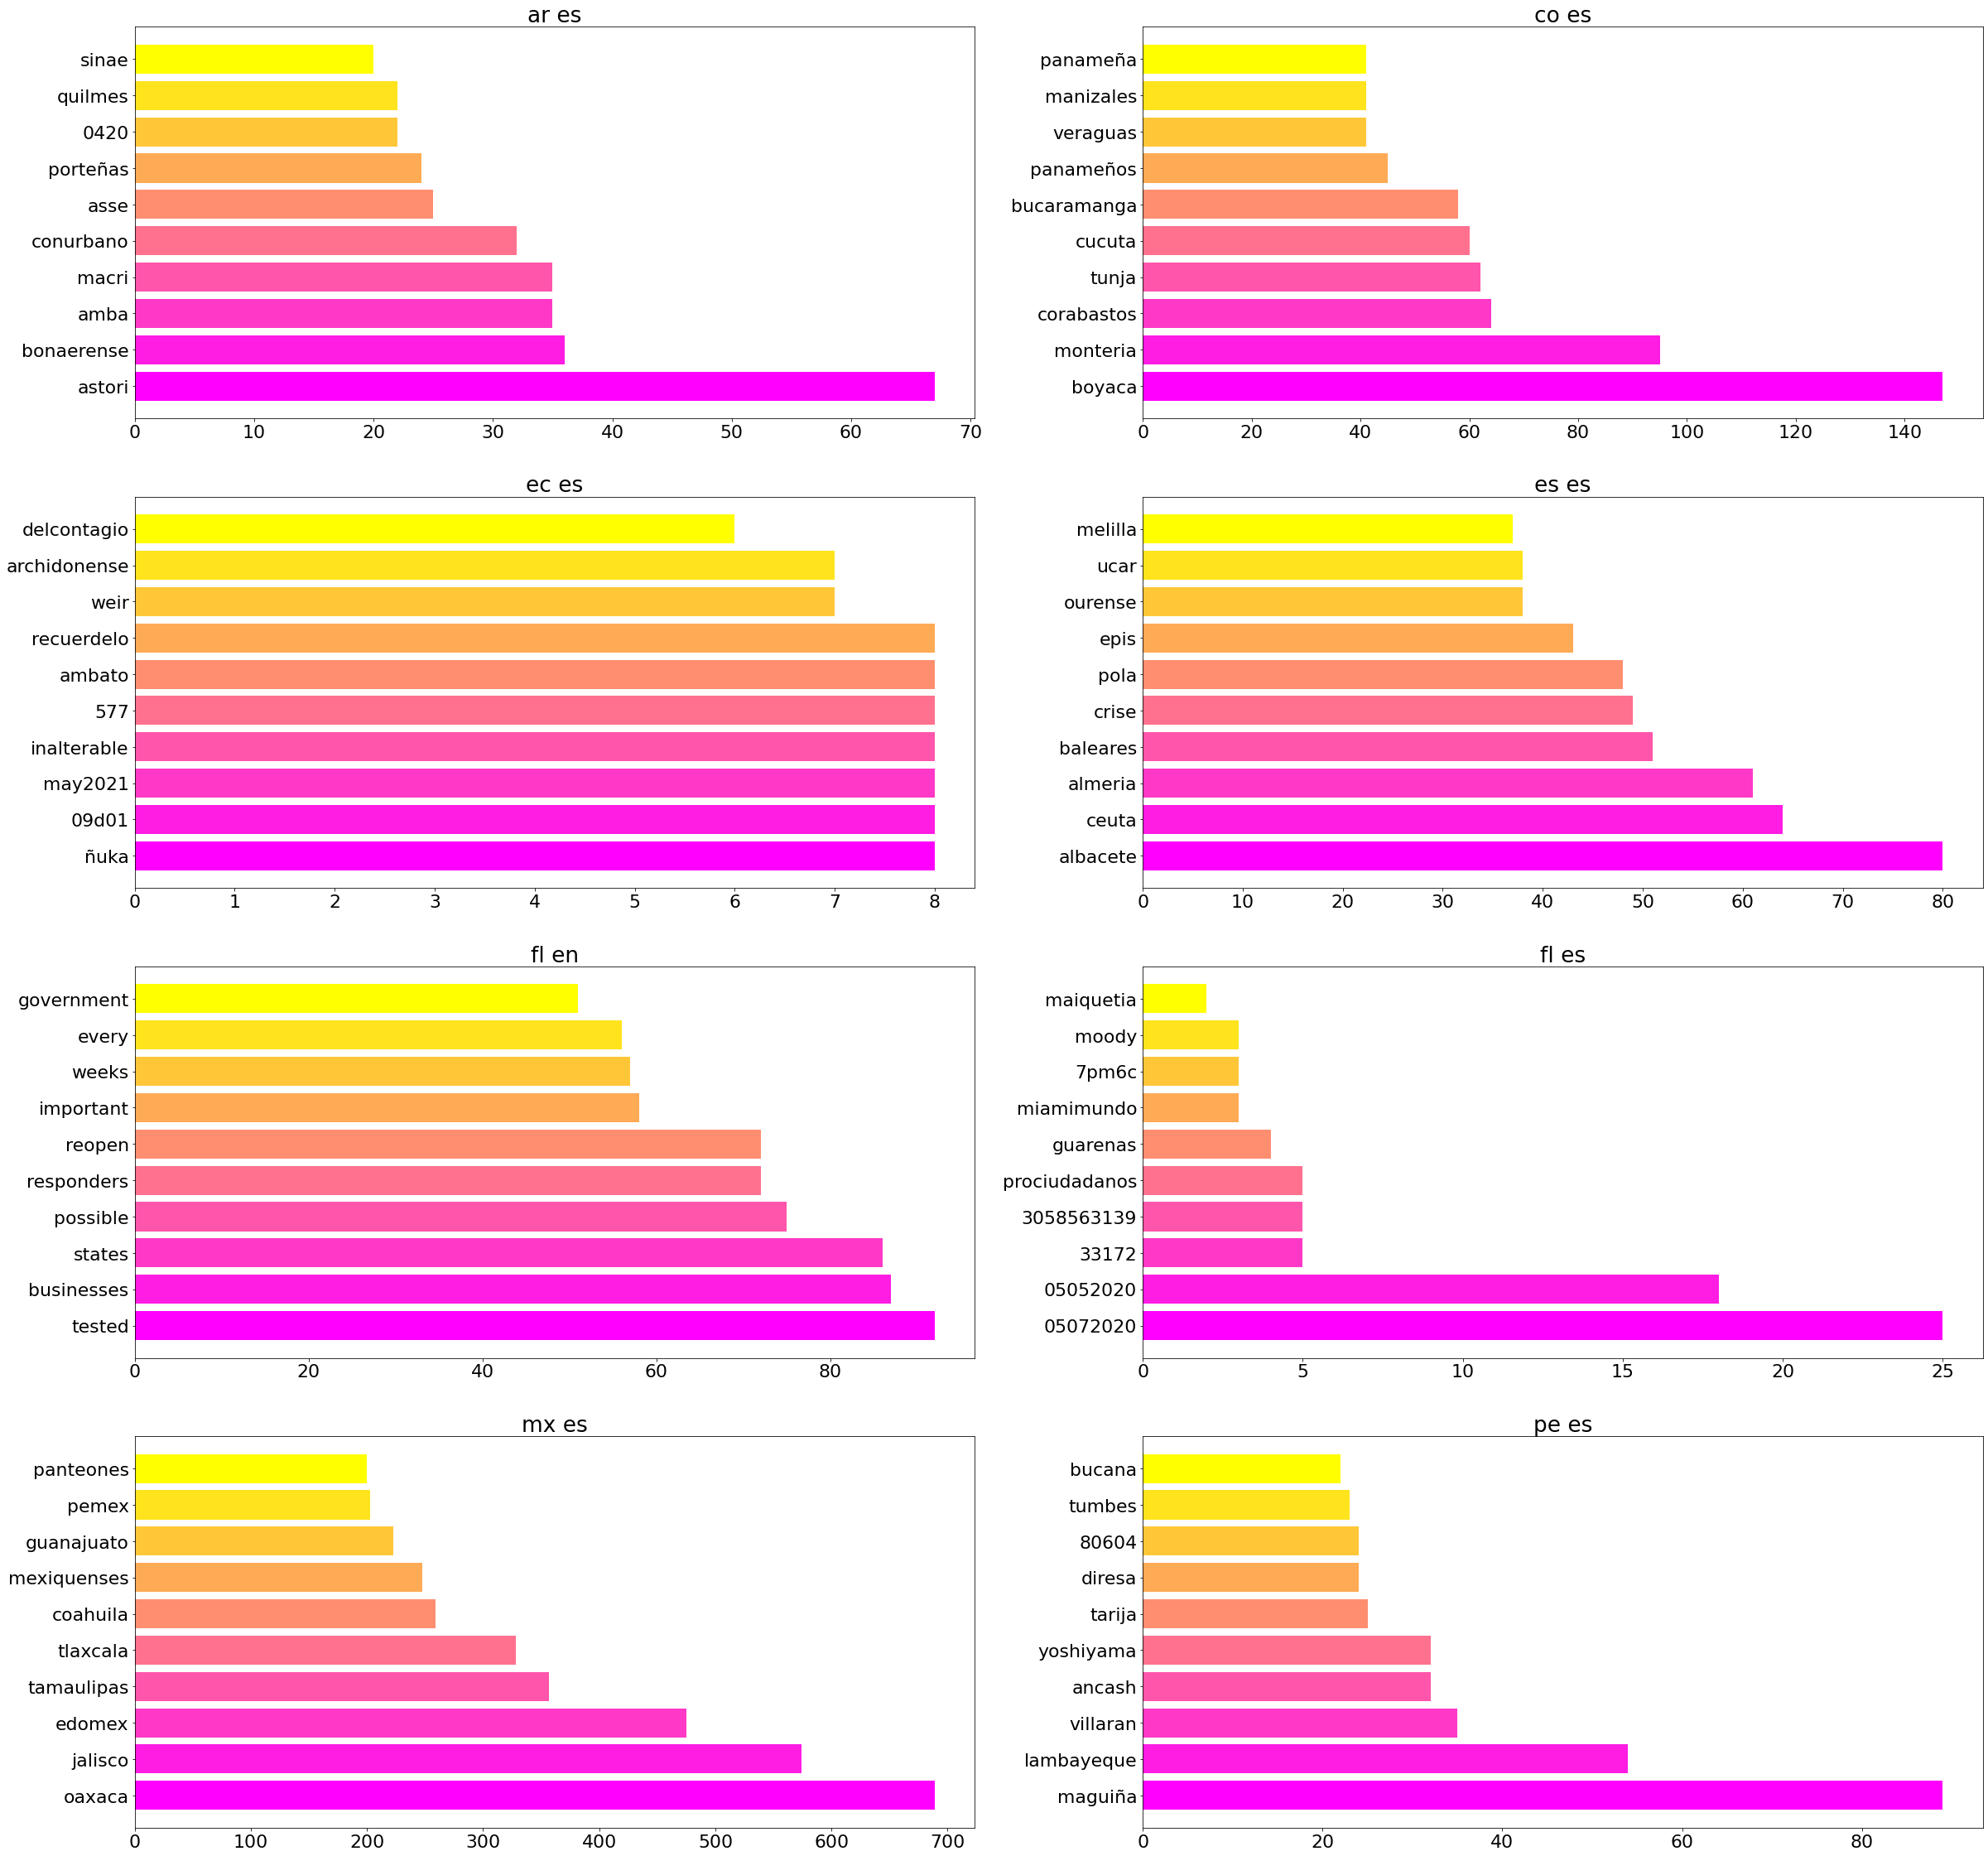

In [70]:
plot_bar_matrix(counts)

Note the words that are most frequent using this method and how it is (or isn't?) in conversation with the pandemic. Some surprising results can be observed: in `fl es`, the phone number `3058563139` is unique to Florida-Spanish and occurs frequently enough to make the top list. A quick search reveals this is the contact information for an immigration attorney. 